In [1]:
import numpy as np
import math
import nest
import nest.raster_plot
import matplotlib.pyplot as plt
import scipy.stats as stats


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: May  5 2022 07:35:57

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
def simulate(itds, ilds, angles, sim_time, rate_group3, rate_group4, rate_group5):
    
    for num_itd in range(len(itds)):
        
        nest.ResetKernel()
        nest.resolution = 0.01 # 10 us = minimum audible angle (MAA) increment of 1.25°

        itd = itds[num_itd]
        ild = ilds[num_itd]
        angle = angles[num_itd]
        print(itd)
        print(ild)
        
        tone = 100
        tone_error = 2
        
        max_ild = 2
        mean_amplitude = 1000

        ANFs2SBCs_weight = 2.0
        ANFs2GBCs_weight = 1.0
        SBCs2MSO_weight = 16.0
        MNTBCs2MSO_weights = [0, -2.0, -4.0, -8.0, -16.0, -32.0, -64.0, -128.0]
        GBCs2MNTBCs_weight = 16.0

        Cm_bushy = 10

        noise_rate = 20

        n_ANFs = 35000
        mean_rate = 0
        ANFs2SBCs = 4
        ANFs2GBCs = 20
        n_SBCs = int(n_ANFs/ANFs2SBCs)
        n_GBCs = int(n_ANFs/ANFs2GBCs)

        freq = np.round(np.logspace(np.log(20),np.log(20000),num = 3500, base = np.exp(1)),2)

        spectro = np.zeros((3500,sim_time))
        channels = len(freq[np.where((freq>tone-tone_error) & (freq<tone+tone_error))])
        amplitudes = stats.norm.pdf(np.linspace(-1, 1, channels) , 0, 1.0/(math.sqrt(2*math.pi)*1))
        spectro[np.where(freq>tone-tone_error)[0][0]:np.where((freq<tone+tone_error))[0][-1]+1, :] = amplitudes.reshape(channels,1)*np.ones((channels, sim_time))

        #angle = 0
        #w_head = 22 #cm
        #v_sound = 33000 #cm/s
        #delta_x = (w_head*np.sin(np.deg2rad(angle)))
        #itd = 1000*delta_x/v_sound #ms
        ipds = 2*np.pi*itd*freq/1000
        #ild = angle*max_ild/90
        
        # Populations

        r_ANFs_amp = nest.Create('sinusoidal_poisson_generator',n_ANFs,
                    params={'frequency': np.repeat(freq, 10),
                            'phase': np.repeat(np.rad2deg(ipds),10)}) #ITDs

        r_ANFs = nest.Create('parrot_neuron',n_ANFs)

        r_SBCs = nest.Create('iaf_cond_alpha', n_SBCs, 
                         params = {'C_m': Cm_bushy, 'V_m': -70})

        r_GBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': Cm_bushy, 'V_m': -70})

        r_MNTBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': Cm_bushy, 'V_m': -70})

        r_MSO = nest.Create('iaf_cond_alpha', n_GBCs*8, 
                         params = {'C_m': Cm_bushy, 'V_m': -70})

        l_ANFs_amp = nest.Create('sinusoidal_poisson_generator',n_ANFs,
                    params={'frequency': np.repeat(freq, 10),
                        'phase': 0})

        l_ANFs = nest.Create('parrot_neuron',n_ANFs)

        l_SBCs = nest.Create('iaf_cond_alpha', n_SBCs, 
                         params = {'C_m': Cm_bushy, 'V_m': -70})

        l_GBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': Cm_bushy, 'V_m': -70})

        l_MNTBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': Cm_bushy, 'V_m': -70})

        #l_MSO = nest.Create('iaf_cond_alpha', n_GBCs, 
         #                params = {'C_m': 23, 'V_m': -70})

        ANFs_noise = nest.Create('poisson_generator',1,
                         params = {'rate':noise_rate})

        s_rec_r = nest.Create('spike_recorder')
        s_rec_l = nest.Create('spike_recorder')

        nest.Connect(r_ANFs_amp, r_ANFs, 'one_to_one')
        nest.Connect(l_ANFs_amp, l_ANFs, 'one_to_one')

        nest.Connect(r_ANFs, s_rec_r, 'all_to_all')
        nest.Connect(l_ANFs, s_rec_l, 'all_to_all')

        nest.Connect(r_SBCs, s_rec_r, 'all_to_all')
        nest.Connect(l_SBCs, s_rec_l, 'all_to_all')

        nest.Connect(r_GBCs, s_rec_r, 'all_to_all')
        nest.Connect(l_GBCs, s_rec_l, 'all_to_all')

        nest.Connect(r_MNTBCs, s_rec_r, 'all_to_all')
        nest.Connect(l_MNTBCs, s_rec_l, 'all_to_all')

        nest.Connect(r_MSO, s_rec_r, 'all_to_all')

        #nest.Connect(l_MSO, s_rec_l, 'all_to_all')

        for r in range(len(spectro)-1):
            if(np.any(spectro[r][:] > 0)):
                nest.Connect(ANFs_noise, r_ANFs[10*r:10*(r+1)], 'all_to_all')
                nest.Connect(ANFs_noise, l_ANFs[10*r:10*(r+1)], 'all_to_all')

        for j in range(n_SBCs):
            nest.Connect(r_ANFs[j*ANFs2SBCs:j*ANFs2SBCs+ANFs2SBCs], r_SBCs[j], 'all_to_all', syn_spec = {"weight":ANFs2SBCs_weight})
            nest.Connect(l_ANFs[j*ANFs2SBCs:j*ANFs2SBCs+ANFs2SBCs], l_SBCs[j], 'all_to_all', syn_spec = {"weight":ANFs2SBCs_weight})

        for k in range(n_GBCs):
            nest.Connect(r_ANFs[k*ANFs2GBCs:k*ANFs2GBCs+ANFs2GBCs], r_GBCs[k], 'all_to_all', syn_spec = {"weight":ANFs2GBCs_weight})
            nest.Connect(l_ANFs[k*ANFs2GBCs:k*ANFs2GBCs+ANFs2GBCs], l_GBCs[k], 'all_to_all', syn_spec = {"weight":ANFs2GBCs_weight})

        for w in range(n_GBCs):
            for y in range(8):
                nest.Connect(r_SBCs[w*int(ANFs2GBCs/ANFs2SBCs):w*int(ANFs2GBCs/ANFs2SBCs)+int(ANFs2GBCs/ANFs2SBCs)], r_MSO[w*8 + y], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight})
                nest.Connect(l_SBCs[w*int(ANFs2GBCs/ANFs2SBCs):w*int(ANFs2GBCs/ANFs2SBCs)+int(ANFs2GBCs/ANFs2SBCs)], r_MSO[w*8 + y], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight})    

        nest.Connect(r_GBCs, r_MNTBCs, 'one_to_one', syn_spec = {"weight":GBCs2MNTBCs_weight})
        nest.Connect(l_GBCs, l_MNTBCs, 'one_to_one', syn_spec = {"weight":GBCs2MNTBCs_weight})

        for w in range(n_GBCs):
            for y in range(8):
                nest.Connect(l_MNTBCs[w], r_MSO[w*8 + y], 'all_to_all', syn_spec = {"weight":MNTBCs2MSO_weights[y]})

        mm = nest.Create('multimeter', 1, {'record_from': ['V_m']})
        nest.SetStatus(mm, {'interval': 0.01})
        nest.Connect(mm, r_MSO,'all_to_all')

        if(angle>=0): 
            mean_amplitude_r = mean_amplitude
            mean_amplitude_l = mean_amplitude/(10**(abs(ild)/20))
        else:
            mean_amplitude_l = mean_amplitude
            mean_amplitude_r = mean_amplitude/(10**(abs(ild)/20))

        def input_set_up(spectro, ms): 
            for r in range(0, len(spectro)-1):
                if spectro[r][ms] > 0:
                    r_ANFs_amp[10*r:10*(r+1)].set(amplitude = spectro[r][ms]*mean_amplitude_r)
                    l_ANFs_amp[10*r:10*(r+1)].set(amplitude = spectro[r][ms]*mean_amplitude_l)

        for i in range(sim_time):
            input_set_up(spectro,i)
            nest.Simulate(1)

        data_r = s_rec_r.get('events')
        data_l = s_rec_l.get('events')
        data_mso = mm.get('events')
        
        id_r_ANF1 = r_ANFs[0].get('global_id')
        id_r_SBC1 = r_SBCs[0].get('global_id')
        id_r_GBC1 = r_GBCs[0].get('global_id')
        id_r_MNTBC1 = r_MNTBCs[0].get('global_id')
        id_r_MSO1 = r_MSO[0].get('global_id')
        
        print("--------------------")
        print(np.unique(data_r['senders']))
        print("--------------------")
        
        for h in range(8):
            if((85499+h) in np.unique(data_r['senders'])):
                rate_group3[h][num_itd] = (np.unique(data_r['senders'][np.where(data_r['senders']==85515+h)], return_counts= True)[1][0])/sim_time*1000
            else:
                rate_group3[h][num_itd] = 0
            if((85507+h) in np.unique(data_r['senders'])):
                rate_group4[h][num_itd] = (np.unique(data_r['senders'][np.where(data_r['senders']==85515+h)], return_counts= True)[1][0])/sim_time*1000
            else:
                rate_group4[h][num_itd] = 0
            if((85515+h) in np.unique(data_r['senders'])):
                rate_group5[h][num_itd] = (np.unique(data_r['senders'][np.where(data_r['senders']==85515+h)], return_counts= True)[1][0])/sim_time*1000
            else:
                rate_group5[h][num_itd] = 0
        

        np.savetxt('ILD_rate_group3_itd_{}'.format(round(itd,2)), rate_group3[:,num_itd])
        np.savetxt('ILD_rate_group4_itd_{}'.format(round(itd,2)), rate_group4[:,num_itd])
        np.savetxt('ILD_rate_group5_itd_{}'.format(round(itd,2)), rate_group5[:,num_itd])

In [3]:
itds = np.arange(-1,1.05,0.05)
ilds = np.linspace(-3,3,len(itds))
angles = np.linspace(-90,90,len(itds))
rate_group3 = np.zeros([8, len(itds)])
rate_group4 = np.zeros([8, len(itds)])
rate_group5 = np.zeros([8, len(itds)])


In [4]:
len(itds) - len(ilds)

0

In [ ]:
simulate(itds, ilds, angles, 100, rate_group3, rate_group4, rate_group5)

-1.0
-3.0

Mar 25 23:11:53 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.01 ms.

Mar 25 23:12:21 NodeManager::prepare_nodes [Info]: 
    Preparing 178504 nodes for simulation.

Mar 25 23:12:22 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 178504
    Simulation time (ms): 1
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Mar 25 23:12:23 SimulationManager::run [Info]: 
    Simulation finished.

Mar 25 23:12:23 NodeManager::prepare_nodes [Info]: 
    Preparing 178504 nodes for simulation.

Mar 25 23:12:23 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 178504
    Simulation time (ms): 1
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Mar 25 23:12:24 SimulationManager::run [Info]: 
    Simulation finished.

Mar 25 23:12:24 NodeManager::prepare_nodes [Info]: 
    Preparing 178504 nodes for simulation.

Mar 25 23:12:24 SimulationManager::start_updating_ [Info]: 
    Number o

In [7]:
inhib = [0, -2, -4, -8, -16, -32, -64, -128]

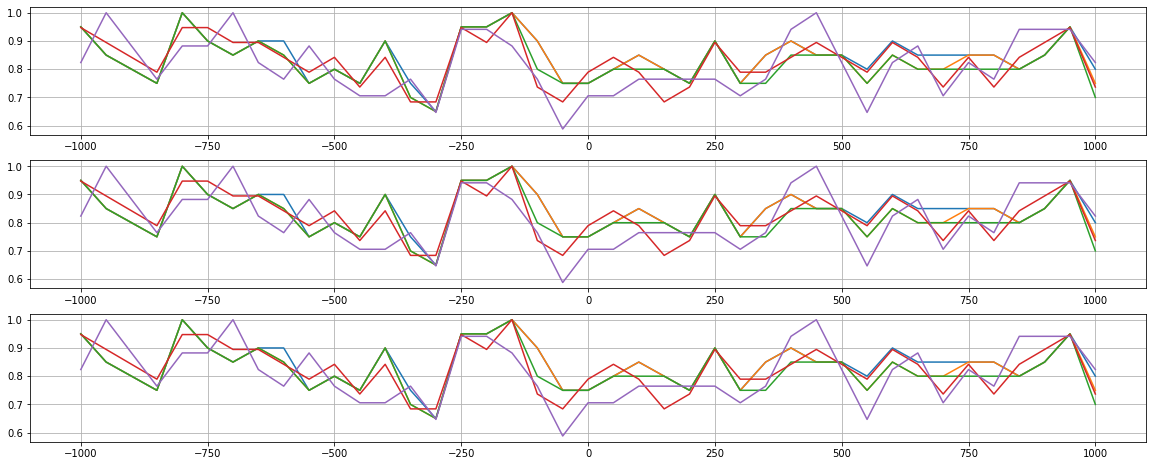

In [8]:
rate_group3_norm = np.zeros([5, len(itds)])
rate_group4_norm = np.zeros([5, len(itds)])
rate_group5_norm = np.zeros([5, len(itds)])
plt.figure(figsize = (20,8))
plt.ylabel('Firing Rate [Hz]')
plt.xlabel("ITDs [us]")
for i in range(5):
    rate_group3_norm[i][:] = rate_group3[i][:]/np.max(rate_group3[i][:])
    rate_group4_norm[i][:] = rate_group4[i][:]/np.max(rate_group4[i][:])
    rate_group5_norm[i][:] = rate_group5[i][:]/np.max(rate_group5[i][:])
    plt.subplot(311)
    plt.plot(itds*1000, rate_group3_norm[i][:])
    plt.grid()
    plt.subplot(312)
    plt.plot(itds*1000, rate_group4_norm[i][:])
    plt.grid()
    plt.subplot(313)
    plt.plot(itds*1000, rate_group5_norm[i][:])
    plt.grid()

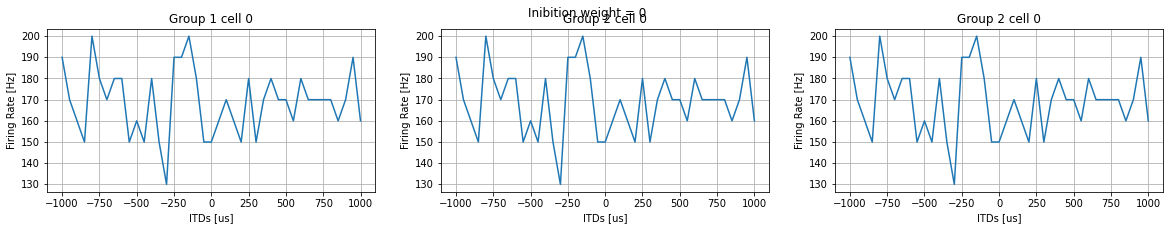

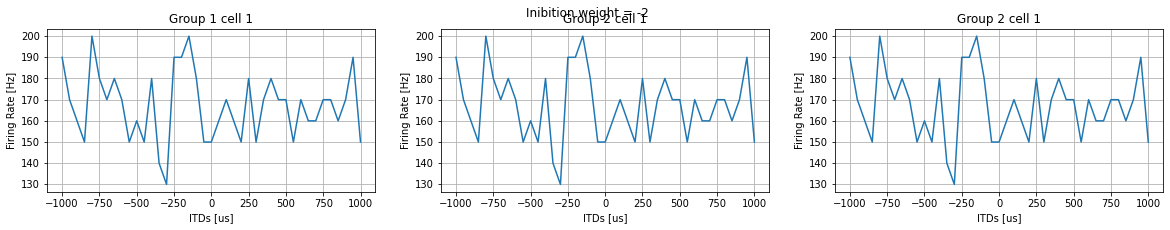

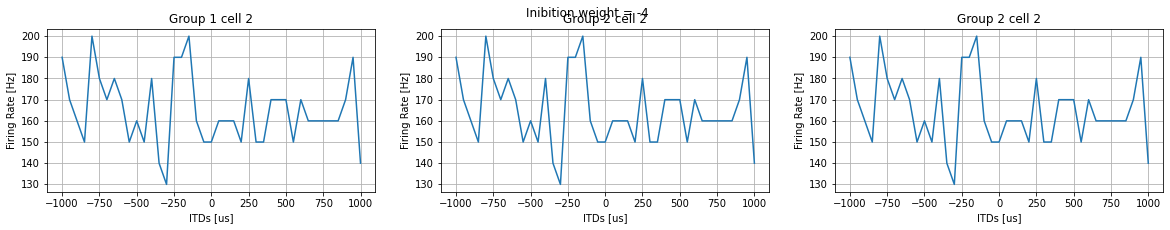

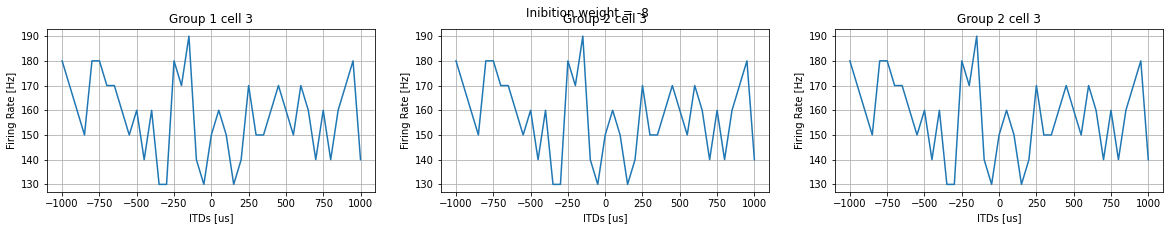

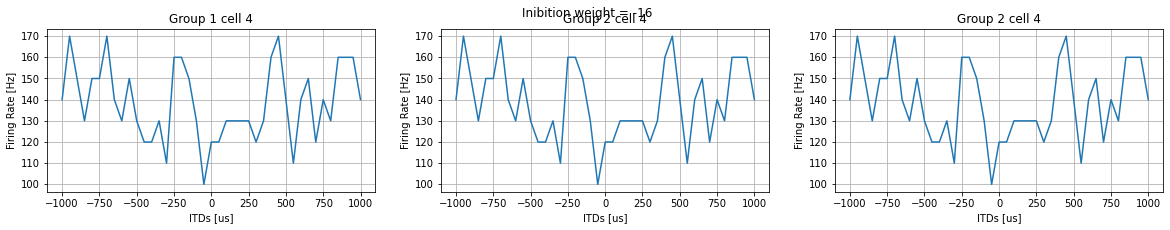

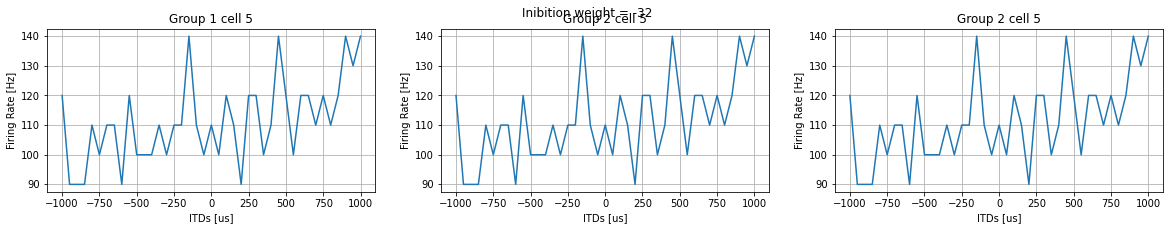

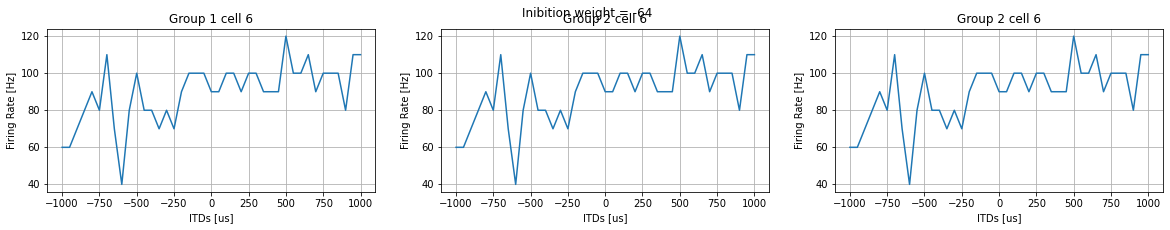

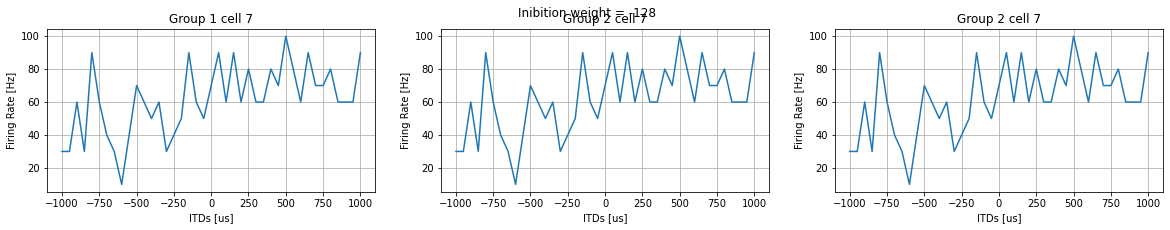

In [9]:
for i in range(8):
    plt.figure(figsize = (20,3))
    plt.suptitle("Inibition weight = {}".format(inhib[i]))
    plt.subplot(131)
    plt.title("Group 1 cell {}".format(i))
    plt.plot(itds*1000, rate_group3[i][:])
    plt.ylabel('Firing Rate [Hz]')
    plt.xlabel("ITDs [us]")
    plt.grid()
    plt.subplot(132)
    plt.plot(itds*1000, rate_group4[i][:])
    plt.ylabel('Firing Rate [Hz]')
    plt.xlabel("ITDs [us]")
    plt.title("Group 2 cell {}".format(i))
    plt.grid()
    plt.subplot(133)
    plt.plot(itds*1000, rate_group5[i][:])
    plt.ylabel('Firing Rate [Hz]')
    plt.xlabel("ITDs [us]")
    plt.title("Group 2 cell {}".format(i))
    plt.grid()

In [ ]:
rate_group3_norm = np.zeros([5, len(itds)])
rate_group4_norm = np.zeros([5, len(itds)])
plt.figure(figsize = (20,8))
plt.ylabel('Firing Rate [Hz]')
plt.xlabel("ITDs [us]")
for i in range(5):
    rate_group3_norm[i][:] = rate_group3[i][:]/np.max(rate_group3[i][:])
    rate_group4_norm[i][:] = rate_group4[i][:]/np.max(rate_group4[i][:])
    plt.subplot(121)
    plt.plot(itds*1000, rate_group3_norm[i][:])
    plt.grid()
    plt.subplot(122)
    plt.plot(itds*1000, rate_group4_norm[i][:])
    plt.grid()